In [88]:
import os
from typing import Dict

import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
# We will use the following models for our boosting
from sklearn.ensemble import GradientBoostingClassifier
# We will use the following models for our ensemble learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from xgboost import XGBClassifier
import warnings

TRAINING_DATASET_SOURCE = '../training_data.csv'
TEST_DATASET_SOURCE = '../test_data.csv'

os.environ["OMP_NUM_THREADS"] = '5'

categorical_to_numerical = {
    'luminosity': {
        'LOW_LIGHT': 0,
        'LIGHT': 0,
        'DARK': 1
    },
}

"""
'avg_rain': {
    'Sem Chuva': 0,
    'chuva fraca': 1,
    'chuva moderada': 1,
    'chuva forte': 1,
}"""


def convert_record_date(df: pd.DataFrame) -> pd.DataFrame:
    df_ = df.copy()

    record_date = pd.DatetimeIndex(df_['record_date'])

    df_.drop('record_date', axis=1, inplace=True)

    df_['hour'] = record_date.hour
    df_['day'] = record_date.day
    df_['month'] = record_date.month
    df_['weekday'] = record_date.weekday
    df_['hour'] = record_date.hour

    return df_


def hour_of_the_day(hour):
    if hour >= 20 or 0 <= hour <= 6:
        return 0
    elif 7 <= hour <= 19:
        return 1

    return 2


def data_preprocessing(df):
    dropped_columns = ['city_name', 'avg_precipitation', 'magnitude_of_delay', 'avg_rain']

    prep_df = df.drop(dropped_columns, axis=1)
    prep_df.drop_duplicates()
    prep_df.replace(categorical_to_numerical, inplace=True)

    prep_df = convert_record_date(prep_df)

    num_affected_roads = []
    for line in df['affected_roads']:
        unique_roads = set(str(line).split(','))
        valid_roads = [elem for elem in unique_roads if elem != '']
        count = len(valid_roads)
        num_affected_roads.append(count)
    prep_df['num_affected_roads'] = num_affected_roads
    prep_df.drop(columns=['affected_roads'],
                 inplace=True)  # FIXME: Dropping the num_affected_roads for now

    delay_in_minutes = prep_df['delay_in_seconds'].map(lambda seconds: seconds / 60)

    prep_df.drop(columns=['delay_in_seconds'], inplace=True)
    prep_df['delay_in_minutes'] = delay_in_minutes

    est = KBinsDiscretizer(n_bins=2, strategy='kmeans', encode='ordinal')
    prep_df['delay'] = est.fit_transform(prep_df[['delay_in_minutes']])
    prep_df.drop(columns=['delay_in_minutes'], inplace=True) # FIXME: Dropping the deplay_in_minutes for now

    prep_df["hour"] = prep_df["hour"].apply(hour_of_the_day)

    numerical_features = [
        'num_affected_roads', 'hour', 'day', 'month', 'weekday', 'avg_temperature', 'avg_atm_pressure',
        'avg_wind_speed', 'avg_humidity'
    ]
    #prep_df[numerical_features] = MinMaxScaler().fit_transform(prep_df[numerical_features])

    return prep_df


def data_splitting(df):
    X = data_preprocessing(df.drop('incidents', axis=1))
    y = df['incidents']

    return train_test_split(X, y, test_size=0.3, random_state=42)


def pre_data_preparation(train: pd.DataFrame) -> pd.DataFrame:
    #print(train['incidents'].value_counts())

    incidents_count = train['incidents'].value_counts()

    max_count = incidents_count.max()
    #print('Max value count:', max_count)

    df_classes = []
    for category, counts in zip(incidents_count.index, incidents_count):
        df_classes.append(train[train['incidents'] == category])

    df_classes_over = []

    for category in df_classes:
        df_classes_over.append(category.sample(max_count, replace=True, random_state=42))

    df_test_over = pd.concat(df_classes_over, axis=0)

    #print(df_test_over['incidents'].value_counts())

    return df_test_over


# noinspection PyPep8Naming
def make_submission(submission_X: pd.DataFrame, submission_model: GridSearchCV):
    predictions = submission_model.predict(submission_X)
    predictions_df = pd.DataFrame(predictions)
    predictions_df.index += 1
    predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')


In [89]:
def model_training(X, y):
    train_model = CatBoostClassifier(loss_function="MultiClass", verbose=False)

    grid = {
        'learning_rate': [0.1],  #[0.1125, 0.125, 0.1375],
        'depth': [10],
        'l2_leaf_reg': [1],
        'early_stopping_rounds': [10]  #[10, 20, 40],
    }

    grid_search_result = train_model.grid_search(grid, X, y, plot=True, cv=5)

    params = grid_search_result['params']
    cv_results = grid_search_result['cv_results']

    print("Best Parameters:", params)

    #for v in ["test-MultiClass-mean", "test-MultiClass-std", "train-MultiClass-mean", "train-MultiClass-std"]:
    #    print(f"Cross-validation {v}:", cv_results[v])

    train_score = train_model.score(X, y)

    print("[Train] Accuracy:", train_score)

    return train_model


In [90]:
# noinspection PyPep8Naming
def model_evaluation(X_test: pd.DataFrame, y_test: pd.Series):  # -> float:
    print("y_test Value counts:", y_test.value_counts())

    y_test.reset_index(drop=True, inplace=True)

    model_predictions = model.predict(X_test)
    print(f'Plotting Confusion Matrix for CatBoost')

    plt.figure()
    cm = confusion_matrix(y_test, model_predictions)
    # TP FP
    # FN TN
    disp = ConfusionMatrixDisplay(cm)

    disp.plot(cmap='inferno')

    plt.title(f'Confusion Matrix - CatBoost')
    plt.show()

    failed_predications = []

    print("Failed predications:")
    for (model_pred, true_pred, (index, X_value)) in zip(model_predictions, y_test, X_test.iterrows()):
        if model_pred[0] != true_pred:
            #print(f"[{index}]", X_value, 'has been classified as', model_pred, 'and should be', true_pred)
            failed_predications.append([*X_value, true_pred, model_pred[0]])

    print("\n")

    failed_predications_df = pd.DataFrame(failed_predications,
                                          columns=[*X_test.columns, 'True Label', 'Predicated Label'])

    failed_predications_df.to_csv('failed_predications.csv')

    return accuracy_score(y_test, model_predictions)


In [91]:
train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

train_df = pre_data_preparation(train_df)
print('Data Preprocessing done')

Data Preprocessing done


In [92]:
prep_test_df = data_preprocessing(test_df)
print('Preprocessed submission dataset done')

Preprocessed submission dataset done


C:\Users\gonca\.conda\envs\DAA\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [93]:

train_X, test_X, train_y, test_y = data_splitting(train_df)
print('Data splitting done')
print('Data prepared for training')

print('Data shapes:', train_X.shape, test_X.shape, train_y.shape, test_y.shape)

Data splitting done
Data prepared for training
Data shapes: (7098, 11) (3042, 11) (7098,) (3042,)


In [94]:
model = model_training(train_X, train_y)
print('Model Training done')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.2353408207
bestIteration = 530

0:	loss: 0.2353408	best: 0.2353408 (0)	total: 9.66s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 0.2616831438
bestIteration = 489

Training on fold [1/5]

bestTest = 0.255657839
bestIteration = 456

Training on fold [2/5]

bestTest = 0.2617740169
bestIteration = 420

Training on fold [3/5]

bestTest = 0.2393399557
bestIteration = 579

Training on fold [4/5]

bestTest = 0.2376243297
bestIteration = 573

Best Parameters: {'depth': 10, 'od_wait': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
[Train] Accuracy: 0.9967596506058044
Model Training done


y_test Value counts: None         640
Low          608
High         603
Medium       600
Very_High    591
Name: incidents, dtype: int64
Plotting Confusion Matrix for CatBoost


<Figure size 640x480 with 0 Axes>

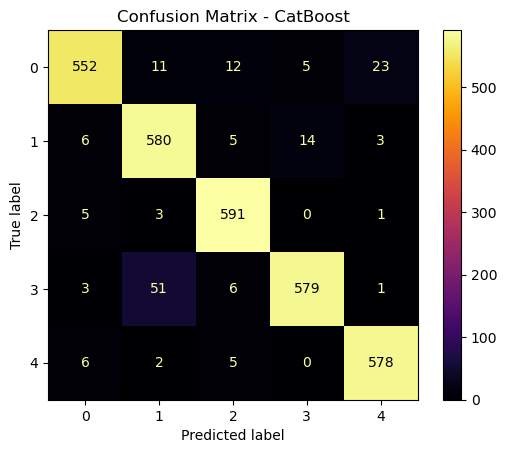

Failed predications:




In [95]:
test_acc = model_evaluation(test_X, test_y)

In [96]:
print(f'Making submission for CatBoost with test accuracy of {test_acc}')
make_submission(prep_test_df, model)

Making submission for CatBoost with test accuracy of 0.9467455621301775
